In [2]:
import torch


def gpu_is_available():
    print('\nGPU details:')
    print(f'    gpu_is_available      : ', torch.cuda.is_available())
    print(f'    cuda_device_count     : ', torch.cuda.device_count())
    print(f'    cuda_device_name      : ', torch.cuda.get_device_name())
    print(f'    cuda_device_capability: ', torch.cuda.get_device_capability(0))


gpu_is_available()


GPU details:
    gpu_is_available      :  True
    cuda_device_count     :  1
    cuda_device_name      :  NVIDIA GeForce RTX 3050 Ti Laptop GPU
    cuda_device_capability:  (8, 6)


In [3]:
def gpu_memory_info():
    if torch.cuda.is_available():
        print('\nGPU Memory details:')
        device = torch.cuda.current_device()
        mem_info = torch.cuda.get_device_properties(device)

        print(f'    total_memory: {mem_info.total_memory / (1024 ** 2)} MB')
        print(f'    allocated_memory: {torch.cuda.memory_allocated(device) / (1024 ** 2)} MB')
        print(f'    reserved_memory: {torch.cuda.memory_reserved(device) / (1024 ** 2)} MB')

gpu_memory_info()


GPU Memory details:
    total_memory: 4095.5 MB
    allocated_memory: 0.0 MB
    reserved_memory: 0.0 MB


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def accuracy(outputs, labels):
    _, pred_s = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(torch.Tensor(pred_s == labels)).item() / len(pred_s), dtype=torch.float32)


@torch.no_grad()
def evaluate(model, val_loader):
    """评估模型在验证集上的性能"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_default_device():
    """获取默认设备，如果有 GPU 则选择 GPU，否则选择 CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """将张量（或张量组成的列表/元组）移动到指定的设备"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """包装数据加载器，将数据移动到指定设备上"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """将数据移动到设备后，产生一个批次的数据"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """批次数量"""
        return len(self.dl)

In [4]:
import time
import torch.nn as nn
import torch.nn.functional as f


class ImageClassificationBase(nn.Module):
    @staticmethod
    def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
        """训练模型并在每个 epoch 结束后在验证集上评估性能"""
        history = []
        optimizer = opt_func(model.parameters(), lr, weight_decay=1e-5)
        start_time = time.time()  # 记录开始时间

        # 第一阶段：冻结层的初始训练
        print("第一阶段训练")
        for epoch in range(epochs):
            model.train()
            train_losses = []
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # 每个 epoch 结束后的验证阶段
            result = evaluate(model, val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            model.epoch_end(epoch, result)
            history.append(result)

            end_time = time.time()  # 记录每一轮的结束时间
            epoch_time = end_time - start_time  # 计算每一轮的时间
            print(f"第 {epoch + 1} 轮训练时间: {epoch_time // 60} 分 {epoch_time % 60} 秒")

            # 更新最佳模型参数
            if result['val_acc'] > model.best_accuracy:
                model.best_accuracy = result['val_acc']
                model.best_model_state = model.state_dict()

        model.load_state_dict(model.best_model_state)
        # 解冻层进行微调
        for param in model.parameters():
            param.requires_grad = True

        # 第二阶段：使用较低的学习率进行微调
        optimizer = opt_func(model.parameters(), lr=0.0001)
        print("第二阶段微调")
        for epoch in range(epochs):
            model.train()
            train_losses = []
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # 每个 epoch 结束后的验证阶段
            result = evaluate(model, val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            model.epoch_end(epoch, result)
            history.append(result)

            end_time = time.time()  # 记录每一轮的结束时间
            epoch_time = end_time - start_time  # 计算每一轮的时间
            print(f"第 {epoch + 1} 轮训练时间: {epoch_time // 60} 分 {epoch_time % 60} 秒")

            # 更新最佳模型参数
            if result['val_acc'] > model.best_accuracy:
                model.best_accuracy = result['val_acc']
                model.best_model_state = model.state_dict()

        end_time = time.time()  # 记录结束时间
        total_time = end_time - start_time  # 计算总时间
        print(f"训练总时间: {total_time // 60} 分 {total_time % 60} 秒")

        return history

    def training_step(self, batch):
        """
        这里的 f.cross_entropy 会自动应用 softmax 激活函数，并计算交叉熵损失
        :param batch:
        :return:
        """
        images, labels = batch
        out = self(images)  # 生成预测
        loss = f.cross_entropy(out, labels)  # 计算损失
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # 生成预测
        loss = f.cross_entropy(out, labels)  # 计算损失
        acc = accuracy(out, labels)  # 计算准确率
        return {'val_loss': loss.detach(), 'val_acc': acc}

    @staticmethod
    def validation_epoch_end(outputs):
        # 将损失列表转换为张量并计算均值
        batch_losses = torch.stack([x['val_loss'] for x in outputs])
        epoch_loss = batch_losses.mean()

        # 将准确率列表转换为张量并计算均值
        batch_acc_s = torch.stack([x['val_acc'] for x in outputs])
        epoch_acc = batch_acc_s.mean()

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    @staticmethod
    def epoch_end(epoch, result):
        print(
            f"第 {epoch + 1} 轮: 训练损失: {result['train_loss']:.4f}, 验证损失: {result['val_loss']:.4f}, "
            f"验证准确率: {result['val_acc']:.4f}")


In [5]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights


# 预训练模型 ResNet-50
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.best_accuracy = 0.0
        self.best_model_state = None  # 最高测试集评分的参数副本
        # 使用预训练模型 ResNet-50
        self.network = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # 修改模型的第一层，使其适应单通道输入
        self.network.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # 替换最后一层全连接层
        num_ftrs = self.network.fc.in_features
        # dataset2 demo2
        self.network.fc = nn.Linear(num_ftrs, 10)  # 数字0-9

    def forward(self, xb):
        # 使用 sigmoid 函数处理输出
        return torch.sigmoid(self.network(xb))

    def save_model(self):
        """
        保存模型
        """
        # 转换百分比形式
        accuracy_percent = f'{self.best_accuracy * 100:.2f}%'
        # 保存最佳模型参数和整个模型
        best_model_weights_filename = f'./model/{accuracy_percent}_model_weights.pth'
        # best_model_filename = f'./model/{accuracy_percent}_entire_model.pth'
        torch.save(self.best_model_state, best_model_weights_filename)
        # torch.save(self, best_model_filename)

    def load_model_dict(self, path):
        """
        加载模型的权重
        :param path: 路径
        """
        self.load_state_dict(torch.load(path))
        self.eval()  # 设置为评估模式

In [6]:
# -*- coding: utf-8 -*-
"""
@File  : config.py
@author: FxDr
@Time  : 2023/11/23 23:16
@Description:
"""
import torch
import torchvision.transforms as transforms  # transforms 模块包含用于图像预处理的各种转换操作

# 训练参数
num_epochs = 10  # 轮次
opt_func = torch.optim.Adam  # 优化器
lr = 5.5e-5  # 学习率
batch_size = 64  # 批次大小
# split_sizes = [55000, 500, 10000]  # 训练集验证集测试集图片数

# 转换器，将数据转换为tensor并归一化
# 数据增强防止过拟合
transformers = {
    # 原始处理
    'original': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'demo1': transforms.Compose([
        transforms.Resize((28, 28)),  # 其实不需要这一步，因为数据集已经是被处理好了的，都是28x28
        # 随机图像亮度、对比度、饱和度
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        # 随机翻转
        # transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(5),
        # 随机放射变化
        transforms.RandomAffine(degrees=11, translate=(0.1, 0.1), scale=(0.8, 0.8)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),

}

In [12]:
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import MNIST

train_dataset = MNIST(root='../data', train=True, transform=transformers['demo1'], download=False)
test_dataset = MNIST(root='../data', train=False, transform=transformers['demo1'], download=False)  # 测试集
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[-11.0, 11.0], translate=(0.1, 0.1), scale=(0.8, 0.8))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [13]:
# 划分训练集为训练集和验证集
train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])

# 数据加载器
# batch_size*2 验证集的批量大小是训练集的两倍
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=4)

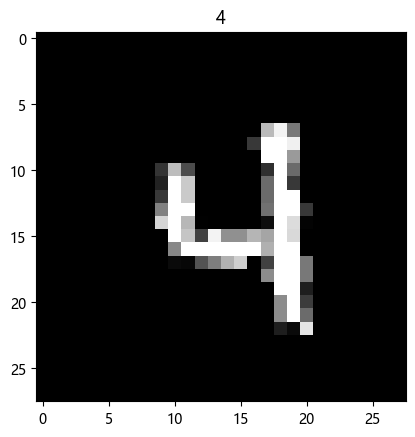

In [14]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Microsoft YaHei'

image, label = train_dataset[0]
plt.title(label)
plt.imshow(image.squeeze().numpy(), cmap='gray')

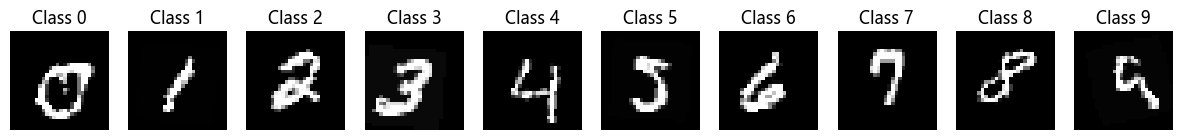

In [30]:
class_samples = {i: None for i in range(10)}

# Find one sample from each class
for data, target in train_dataset:
    if class_samples[target] is None:
        class_samples[target] = data
    if all(sample is not None for sample in class_samples.values()):
        break

# Visualize the samples
fig, axs = plt.subplots(1, 10, figsize=(15, 3))
for i, (class_idx, sample) in enumerate(class_samples.items()):
    axs[i].imshow(sample.squeeze().numpy(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Class {class_idx}')

plt.show()

In [19]:
# 创建 ResNet 模型实例
model = ResNet()

# 移动到GPU
device = get_default_device()
print("Using device:{}".format(device))
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

Using device:cuda


ResNet(
  (network): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
 # training
history = model.fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
import matplotlib.pyplot as plt

# 中文绘制
plt.rcParams['font.family'] = 'Microsoft YaHei'


def plot_accuracies(history):
    """绘制准确率曲线"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()


def plot_losses(history):
    """绘制损失曲线"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()


# 可视化损失和准确率
plot_accuracies(history)
plot_losses(history)

In [ ]:
# 保存模型
# model.save_model()